In [1]:
import scipy.special
import numpy as np

In this final notebook, we are going to compute the Bézier curves as matrix operations. This approach will make it easier to accelerate the computation, since matrix operations can be easily implemented as CUDA kernels.

We'll start by writing the general Bézier formula for a concrete degree. In the plane or in higher-dimensional space, define a 5th order Bézier
curve with six points [P0, P1, P2, P3, P4, P5] has the following equation:

$$ bezier(t) =  \sum_{k=1}^{5} \binom{5}{k} * (1-t)^{5-k} * t^{k}$$

This equation can be translated into a matrix equivalent, if we keep with the same curve degree, the matrix representation of 5th order Bézier curve with control points is the following:

\begin{multline}
  bezier(t) = 
  \begin{pmatrix}
      t^5 & t^4 & t^3 & t^2 & t^1 &t & 1
  \end{pmatrix} *
  \begin{pmatrix}
    -1 & 5 & −10 & 10 & −5 & 1 \\
    5 & −20 & 30 & −20 &  5 &  0 \\ 
    −10 & 30 & −30 & 10 & 0 &  0 \\ 
    10 & −20 & 10 & 0 & 0 & 0 \\ 
    −5 & 5 &  0 & 0 & 0 & 0 \\
    1 & 0 & 0 & 0 & 0 & 0 \\
  \end{pmatrix} *
  \begin{pmatrix}
      P0 \\ P1 \\ P2 \\ P3 \\ P4 \\ P5
  \end{pmatrix}
 \end{multline}

The coefficient matrix of 5th order of Bézier curve. Those coefficients
are calculated with the initial letters of 5th order Bézier curve. By looking at the result matrix, we can start to identify how to generalize a method to compute the coefficients for any general degree.


\begin{multline}
  bezier(t) = 
  \begin{pmatrix}
      t^5 \\ t^4 \\ t^3 \\ t^2 \\ t^1 \\ t \\ 1
  \end{pmatrix}^\top *
  \begin{pmatrix}
    - {5 \choose 0} {5 \choose 5} & \hfill {5 \choose 1} {4 \choose 4} & - {5 \choose 2} {3 \choose 3} & \hfill {5 \choose 3} {2 \choose 2} & - {5 \choose 4} {1 \choose 1} & \hfill {5 \choose 5} {0 \choose 0} \\
    \hfill {5 \choose 0} {5 \choose 4} & - {5 \choose 1} {4 \choose 3} & \hfill {5 \choose 2} {3 \choose 2} & - {5 \choose 3} {2 \choose 1} & \hfill {5 \choose 4} {1 \choose 0} & 0 \\
    - {5 \choose 0} {5 \choose 3} & \hfill {5 \choose 1} {4 \choose 2} & - {5 \choose 2} {3 \choose 1} & \hfill {5 \choose 3} {2 \choose 0} & 0 & 0 \\
    \hfill {5 \choose 0} {5 \choose 2} & - {5 \choose 1} {4 \choose 1} & \hfill {5 \choose 2} {3 \choose 0} & 0 & 0 & 0 \\
    - {5 \choose 0} {5 \choose 1} & \hfill {5 \choose 1} {4 \choose 0} & 0 & 0 & 0 & 0 \\
    \hfill {5 \choose 0} {5 \choose 0} & 0 & 0 & 0 & 0 & 0 \\
  \end{pmatrix} *
  \begin{pmatrix}
      P0 \\ P1 \\ P2 \\ P3 \\ P4 \\ P5
  \end{pmatrix}
 \end{multline}



We can write a simple algorithm to generate the coefficient matrix. Let's split the process into two methods, first we create the matrix with the necessary combinatorial numbers, and then we evaluate the matrix to compute the binomial terms at each position.

In [3]:
def bezier_matrix_binom(grade):

  rows =  []

  for sub in range(grade + 1):

    cols = []

    inv = grade - sub

    for i in range((grade +1) - sub):

      mat = np.array([
            [grade, grade -i],
            [i,    inv -i]
      ])

      cols.append(mat)

    for j in range(i, (grade)):

      cols.append(np.array([
            [0, 0],
            [0, 0]
      ]))

    rows.append(cols)

  return rows

In [4]:
def bezier_matrix_compute(grade):

  rows = bezier_matrix_binom(grade)

  m_2 = np.zeros(shape=(grade+1,grade+1))

  for sub in range(grade + 1):

    mod_grade = (grade +1) % 2

    shift = (1 -(sub % 2) ) if mod_grade == 0 else (sub % 2)

    for i in range((grade +1) - sub):

      sign = 1 

      if ((i + shift) % 2) != 0: 
        sign = -1 

      mat = rows[sub][i]

      comb_0 = scipy.special.binom(mat[0][0], mat[1][0])
      comb_1 = scipy.special.binom(mat[0][1], mat[1][1])

      res = comb_0 * comb_1 * sign

      m_2[sub][i] = res

  return m_2

In [5]:
# the method results in the following output:

bezier_matrix_compute(8)

array([[   1.,   -8.,   28.,  -56.,   70.,  -56.,   28.,   -8.,    1.],
       [  -8.,   56., -168.,  280., -280.,  168.,  -56.,    8.,    0.],
       [  28., -168.,  420., -560.,  420., -168.,   28.,    0.,    0.],
       [ -56.,  280., -560.,  560., -280.,   56.,    0.,    0.,    0.],
       [  70., -280.,  420., -280.,   70.,    0.,    0.,    0.,    0.],
       [ -56.,  168., -168.,   56.,    0.,    0.,    0.,    0.,    0.],
       [  28.,  -56.,   28.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  -8.,    8.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

Once again, we need to generate some random control points, so we can later fit the curve to those points. To test the matrix we have just calculated, we need to create the two other vector arrays, let's fill some points in space for a low grade curve and check the result.

In [7]:
# generate n -dimensional control points:

import random

def r_n_dim_control(dim, elems):
  
    N, R = 5, 10

    return [random.sample(range((R + 1) * (R + 1)), dim) for _ in range(elems) ]

In [8]:
points = r_n_dim_control(2, 6)

In [9]:
i_comps = list(zip(*points))[0]

grade = len(i_comps) -1

t = 0.5

In [10]:
t_arr = np.array([[pow(t, grade - i ) for i in range(grade + 1)]]); t_arr

array([[0.03125, 0.0625 , 0.125  , 0.25   , 0.5    , 1.     ]])

In [11]:
mat = np.array(bezier_matrix_compute(grade)); mat

array([[ -1.,   5., -10.,  10.,  -5.,   1.],
       [  5., -20.,  30., -20.,   5.,   0.],
       [-10.,  30., -30.,  10.,   0.,   0.],
       [ 10., -20.,  10.,   0.,   0.,   0.],
       [ -5.,   5.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.,   0.]])

In [12]:
cmp = np.array([i_comps]); cmp.T

array([[117],
       [ 71],
       [ 58],
       [ 15],
       [ 19],
       [  3]])

In [13]:
# and execute the result:

t_arr.dot(mat).dot(cmp.T)

array([[40.625]])

In [14]:
# sum up previous execution in a single cell

grade = len(i_comps) - 1

t_arr = np.array( [[pow(t, grade - i ) for i in range(grade + 1)]] ) 

mat = np.array( bezier_matrix_compute(grade) ) 

cmp = np.array([i_comps])

res = t_arr.dot(mat).dot(cmp.T)

res.reshape(-2)[0]

40.625

Ok, the method is working so far, now we can encapsulate the behavior into a single function that can be called for any of the desired coordinate components {x,y,z}, for example. The get_point function takes a point collection with any number of dimensions, inside, a zip method decomposes each of the coordinates to vectorize the point array needed in the matrix multiplication.

In [15]:
def bezier_mat(grade, t, i_comps, dot):

  grade = len(i_comps) - 1

  tar = np.array( [[pow(t, grade - i ) for i in range(grade + 1)]] ) 

  mat = np.array( bezier_matrix_compute(grade) )

  cmp = np.array( [i_comps] )

  r_1 = dot(tar, mat)

  r_2 = dot(r_1, cmp.T)

  return (float)(r_2[0,0])

In [16]:
def get_point(points, t, dot):

    grade = len(points)-1

    i_comps = list(zip(*points))

    t_point = [ bezier_mat(grade, t, i_comps[x], dot) for x in range(len(i_comps)) ]

    return t_point

In [17]:
curves_control = [r_n_dim_control(3, 8) for _ in range(3)]

The get_point function is design to take the matrix dot product as a parameter. This way, if we manage to run accelerated matrix multiplication, we simply can pass the function as a parameter and test performance. The next plots use different dot products, the first one uses the np.dot function and the second uses the Cupy cp.dot that runs on the Nvida T4 that this notebook is using.

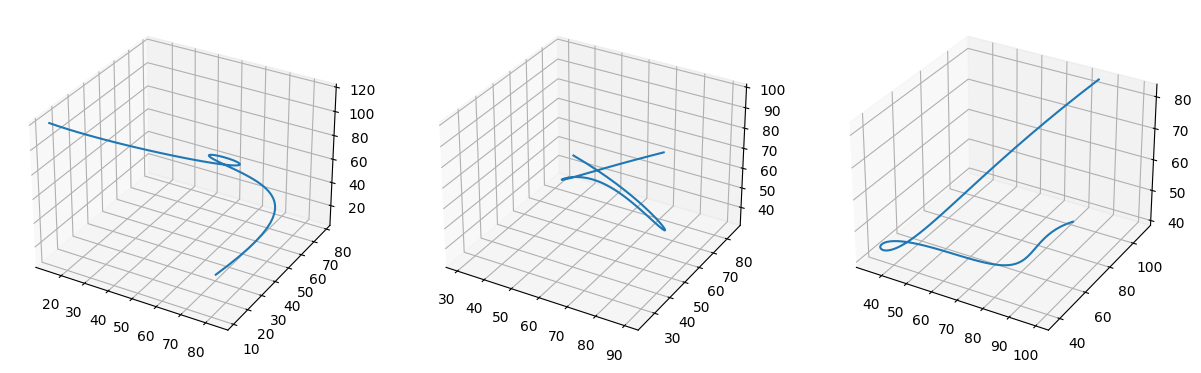

CPU times: user 791 ms, sys: 175 ms, total: 966 ms
Wall time: 833 ms


In [18]:
%%time

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))

beziers = [ [ get_point(curves_control[i], t, np.dot) for t in np.linspace(0.0, 1.0, num=100) ] for i in range(3) ]

for idx, bezier in enumerate(beziers):

    xs, ys, zs = list(zip(*bezier))

    axs[idx].plot(xs, ys, zs)

plt.show()

In [19]:
from numba import jit
from numba import cuda

In [20]:
# executed in device: 

In [21]:
!nvidia-smi

Mon Jun 12 10:24:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
curves_control = [r_n_dim_control(3, 12) for _ in range(3)]

In [23]:
import cupy as cp

def cp_dot(A, B):

  return cp.matmul(cp.array(A), cp.array(B))

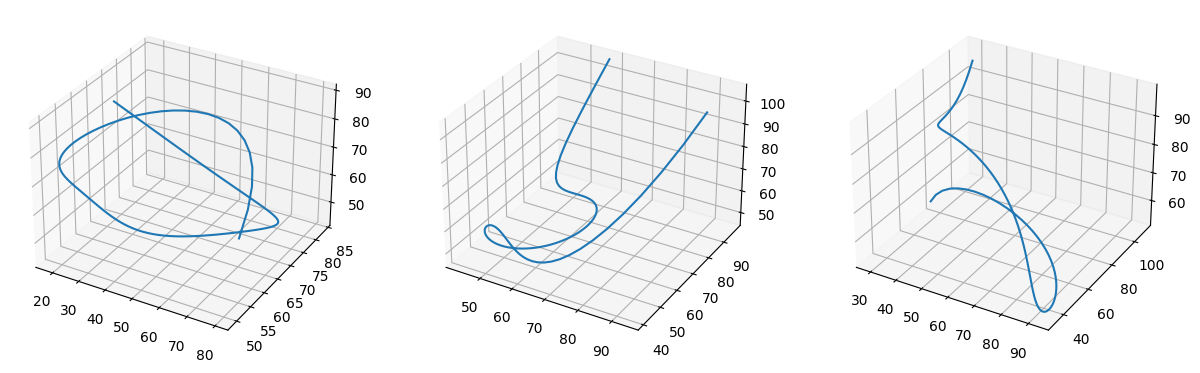

CPU times: user 4.13 s, sys: 675 ms, total: 4.8 s
Wall time: 9.67 s


In [24]:
%%time

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))

beziers = [ [ get_point(curves_control[i], t, cp_dot) for t in np.linspace(0.0, 1.0, num=100) ] for i in range(3) ]

for idx, bezier in enumerate(beziers):

    xs, ys, zs = list(zip(*bezier))

    axs[idx].plot(xs, ys, zs)

plt.show()

Finally, we can encapsulate some of the written behavior into a class. Notice from the beginning matrix equation that the coefficient matrix can be computed just once, since the point weights and mainly the t's matrices are the ones changing. If we need to render a common curve, create the control points and compute the coefficient matrix along the split point components for each coordinate, then evaluate the curve for multiple t values (how many t slices will depend on how smooth the result is required). 

In [25]:
# class to wrap matrix computation:

class Bezier_Matrix():

  def __init__(self, grade, dot):

    """ compute matrix and store it """

    self.grade = grade

    self.dot = dot

    self.mat = np.array( bezier_matrix_compute(grade) )

  def fit (self, points):

    """ fit to the curve control points """

    self.points = points

    self.i_comps = list(zip(*points))

    return self

  def compute (self, t):

    """ evaluate curve at t """

    self.tar = np.array( [[pow(t, grade - i ) for i in range(grade + 1)]] ) 

    # iterate in here:

    r_1 = self.dot(tar, mat)

    r_2 = self.dot(r_1, cmp.T)

    return [ bezier_mat(self.grade, t, self.i_comps[x], self.dot) for x in range(len(self.i_comps)) ]


In [26]:
curves_control = [r_n_dim_control(3, 8) for _ in range(3)]

In [31]:
# elegant way of chaining methods.

Bezier_Matrix(7, np.dot).fit(curves_control[0]).compute(0.5)

[83.71875, 63.4765625, 70.4921875]

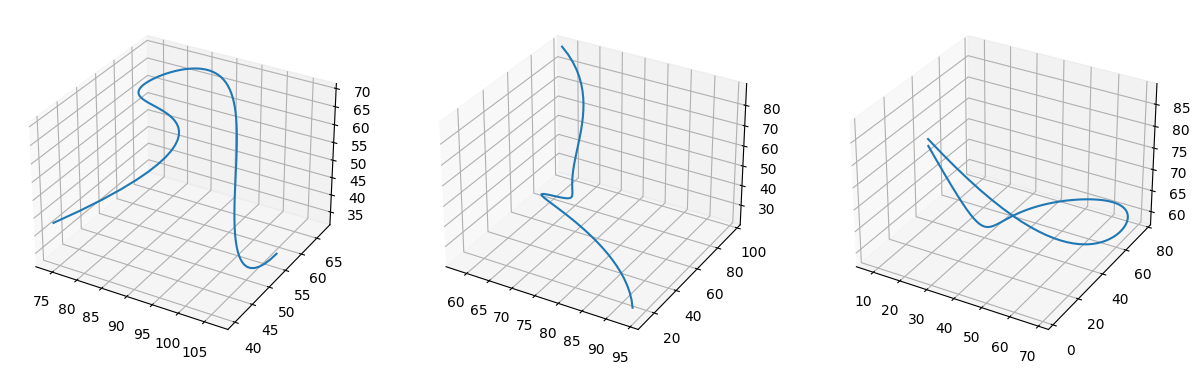

CPU times: user 1.21 s, sys: 127 ms, total: 1.33 s
Wall time: 1.36 s


In [32]:
%%time

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))

beziers = [ Bezier_Matrix(7, np.dot).fit(curves_control[i]) for i in range(3)]

renders = [ [ beziers[i].compute(t) for t in np.linspace(0.0, 1.0, num=100) ] for i in range(3) ]

for idx, render in enumerate(renders):

    xs, ys, zs = list(zip(*render))

    axs[idx].plot(xs, ys, zs)

plt.show()